# 範例 : (Kaggle)房價預測

# [教學目標]
- 以下用房價預測資料, 練習特徵重要性的寫作與觀察
- 由於只有樹狀模型有特徵重要性, 故以梯度提升樹為模型作為範例

# [範例重點]
- 使用擬合過的模型, 計算特徵重要性 (In[3], Out[3]) 
- 對照原始特徵, 觀察特徵重要性較高的一半特徵, 搭配梯度提升樹對於測結果的影響 (In[4], Out[4], In[5], Out[5])
- 重組重要性最高的特徵作為新特徵, 觀察效果如何 (In[8], Out[8]) 

In [1]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor

data_path = 'data/'
df = pd.read_csv(data_path + 'house_train.csv.gz')

train_Y = np.log1p(df['SalePrice'])
df = df.drop(['Id', 'SalePrice'] , axis=1)
df.head()

C:\Users\KenChen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [2]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

C:\Users\KenChen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.235294,0.75,0.210191,0.033420,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.50,1.0,0.8
1,0.000000,0.75,0.257962,0.038795,1.0,0.0,1.0,1.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.363636,0.25,1.0,0.8
2,0.235294,0.75,0.219745,0.046507,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.727273,0.50,1.0,0.8
3,0.294118,0.75,0.194268,0.038561,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.00,1.0,0.0
4,0.235294,0.75,0.270701,0.060576,1.0,0.0,0.0,1.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.50,1.0,0.8


In [3]:
# 梯度提升樹擬合後, 將結果依照重要性由高到低排序
estimator = GradientBoostingRegressor()
estimator.fit(df.values, train_Y)
# estimator.feature_importances_ 就是模型的特徵重要性, 這邊先與欄位名稱結合起來, 才能看到重要性與欄位名稱的對照表
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
feats

GrLivArea        1.033079e-01
OverallQual      7.225535e-02
LotArea          7.044321e-02
OverallCond      5.229426e-02
YearBuilt        4.698460e-02
BsmtFinSF1       3.849221e-02
TotalBsmtSF      3.771998e-02
GarageYrBlt      3.584247e-02
GarageArea       3.545059e-02
SaleCondition    3.191809e-02
Neighborhood     3.061390e-02
MSZoning         3.006163e-02
Functional       2.672018e-02
YearRemodAdd     2.478478e-02
1stFlrSF         2.347506e-02
Exterior1st      1.691164e-02
ScreenPorch      1.641145e-02
BsmtFullBath     1.607052e-02
BsmtUnfSF        1.554843e-02
2ndFlrSF         1.484429e-02
Condition1       1.480486e-02
WoodDeckSF       1.416692e-02
Fireplaces       1.409901e-02
BsmtExposure     1.348751e-02
OpenPorchSF      1.250894e-02
EnclosedPorch    1.243896e-02
PoolArea         1.234143e-02
YrSold           1.087915e-02
LotFrontage      1.057482e-02
BsmtFinType1     8.753685e-03
                     ...     
FireplaceQu      3.378143e-03
MoSold           2.945057e-03
Condition2

In [4]:
# 原始特徵 + 梯度提升樹
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8950550136365223

In [5]:
# 高重要性特徵 + 梯度提升樹 (39大約是79的一半)
high_feature = list(feats[:39].index)
train_X = MMEncoder.fit_transform(df[high_feature])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8958199020238636

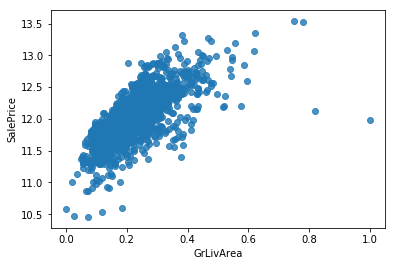

In [6]:
# 觀察重要特徵與目標的分布
# 第一名 : GrLivArea        
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x=df['GrLivArea'], y=train_Y, fit_reg=False)
plt.show()

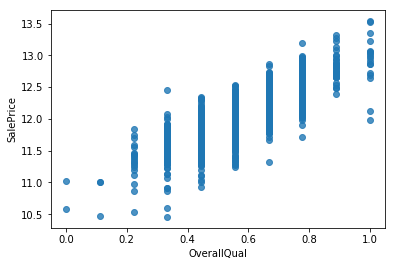

In [8]:
# 第二名 : OverallQual
sns.regplot(x=df['OverallQual'], y=train_Y, fit_reg=False)
plt.show()

In [9]:
# 製作四特徵 : 加, 乘, 互除(分母加1避免除0) 看效果 (Note: 數值原本已經最大最小化介於 [0,1] 區間, 這四種新特徵也會落在 [0,1] 區間)
df['Add_char'] = (df['GrLivArea'] + df['OverallQual']) / 2
df['Multi_char'] = df['GrLivArea'] * df['OverallQual']
df['GO_div1p'] = df['GrLivArea'] / (df['OverallQual']+1) * 2
df['OG_div1p'] = df['OverallQual'] / (df['GrLivArea']+1) * 2
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8950783057944163

## 先用梯度提升機對鐵達尼生存預測做訓練，再用其特徵重要性回答下列問題

# 作業1
* 將特徵重要性較低的一半特徵刪除後，再做生存率預估，正確率是否有變化?

# 作業2
* 將特徵重要性最高的兩個特徵做特徵組合，是否能再進一步提升預測力?